In [92]:
%load_ext autoreload
%autoreload 2
%pylab inline
import pandas as pd
import glob
import seaborn as sns
import pyspiel
import os
import json
from analysis_tools import *
from open_spiel.python.algorithms import cfr, outcome_sampling_mccfr, expected_game_score, exploitability, get_all_states_with_policy
import itertools

sns.set(font_scale=2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [169]:
# df = pd.read_csv('/Users/newmanne/research/cfr/tmp/reduced_strategy.csv')
df = pd.read_csv('/Users/newmanne/research/cfr/open_spiel/output/reduced_strategy.csv')

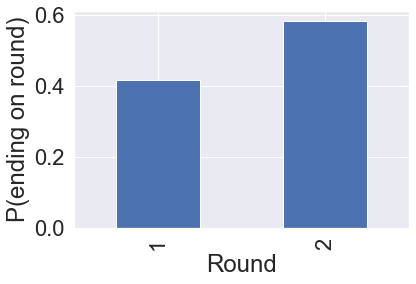

In [170]:
round_probs(df)

In [168]:
expected_values_over_types(df)

Expected Allocation A  Expected Allocation B  \
player type                                                         
0      v150,0b121.0           4.166306e-01           1.388892e-09   
1      v0,150b130.0           1.111113e-09           4.166389e-01   
2      v150,0b110.0           8.333346e-06           1.851853e-16   
       v150,0b130.0           5.555564e-06           5.555558e-06   

                     Expected Utility  
player type                            
0      v150,0b121.0         20.831528  
1      v0,150b130.0         20.831944  
2      v150,0b110.0          0.000417  
       v150,0b130.0         -0.000278

In [87]:
df.columns

Index(['info_state', 'player', 'Allocation 0 A', 'Allocation 0 B',
       'Allocation 1 A', 'Allocation 1 B', 'Allocation 2 A', 'Allocation 2 B',
       'Bid (0 A, 0 B)', 'Bid (0 A, 1 B)', 'Bid (1 A, 0 B)', 'Price A',
       'Price B', 'Utility 0', 'Utility 1', 'Utility 2', 'budget', 'my_bids',
       'prob', 'round', 'terminal', 'total_demand', 'value'],
      dtype='object')

In [171]:
### What do I want my data to look like?
bid_cols = [c for c in df.columns if 'Bid' in c]
action_df = df.query('~terminal')[bid_cols  + ['prob', 'round', 'player', 'type']].copy()
action_df['Player'] = 'p' + action_df['player'].astype(str) + 't' + action_df['type']
action_df.drop(['player', 'type'], inplace=True, axis='columns')
action_df = action_df.rename(columns={'round': 'Round'})
for i in range(3):
    action_df.iloc[:, i] *= action_df['prob']
action_df.drop('prob', inplace=True, axis='columns')
action_df = action_df.groupby(['Player', 'Round']).sum().reset_index().melt(id_vars=['Round', 'Player'], value_name='% Played', var_name='Bid')
action_df


,Round,Player,Bid,% Played
0,1,"p0tv150, 0b121.0","Bid (0 A, 0 B)",0.000000
1,2,"p0tv150, 0b121.0","Bid (0 A, 0 B)",0.583342
2,1,"p1tv0, 150b130.0","Bid (0 A, 0 B)",0.000000
3,2,"p1tv0, 150b130.0","Bid (0 A, 0 B)",0.583342
4,1,"p2tv150, 0b110.0","Bid (0 A, 0 B)",0.250000
5,2,"p2tv150, 0b110.0","Bid (0 A, 0 B)",0.250008
6,2,"p2tv150, 0b130.0","Bid (0 A, 0 B)",0.333333
7,1,"p0tv150, 0b121.0","Bid (0 A, 1 B)",0.000000
8,2,"p0tv150, 0b121.0","Bid (0 A, 1 B)",0.000000
9,1,"p1tv0, 150b130.0","Bid (0 A, 1 B)",1.000000


In [172]:
# Above is unconditional of reaching that round. This renormlizes

def normalize(df):
    normalizer = df['% Played'].sum()
    df['% Played'] /= normalizer
    return df

action_df = action_df.groupby(['Round', 'Player']).apply(normalize)

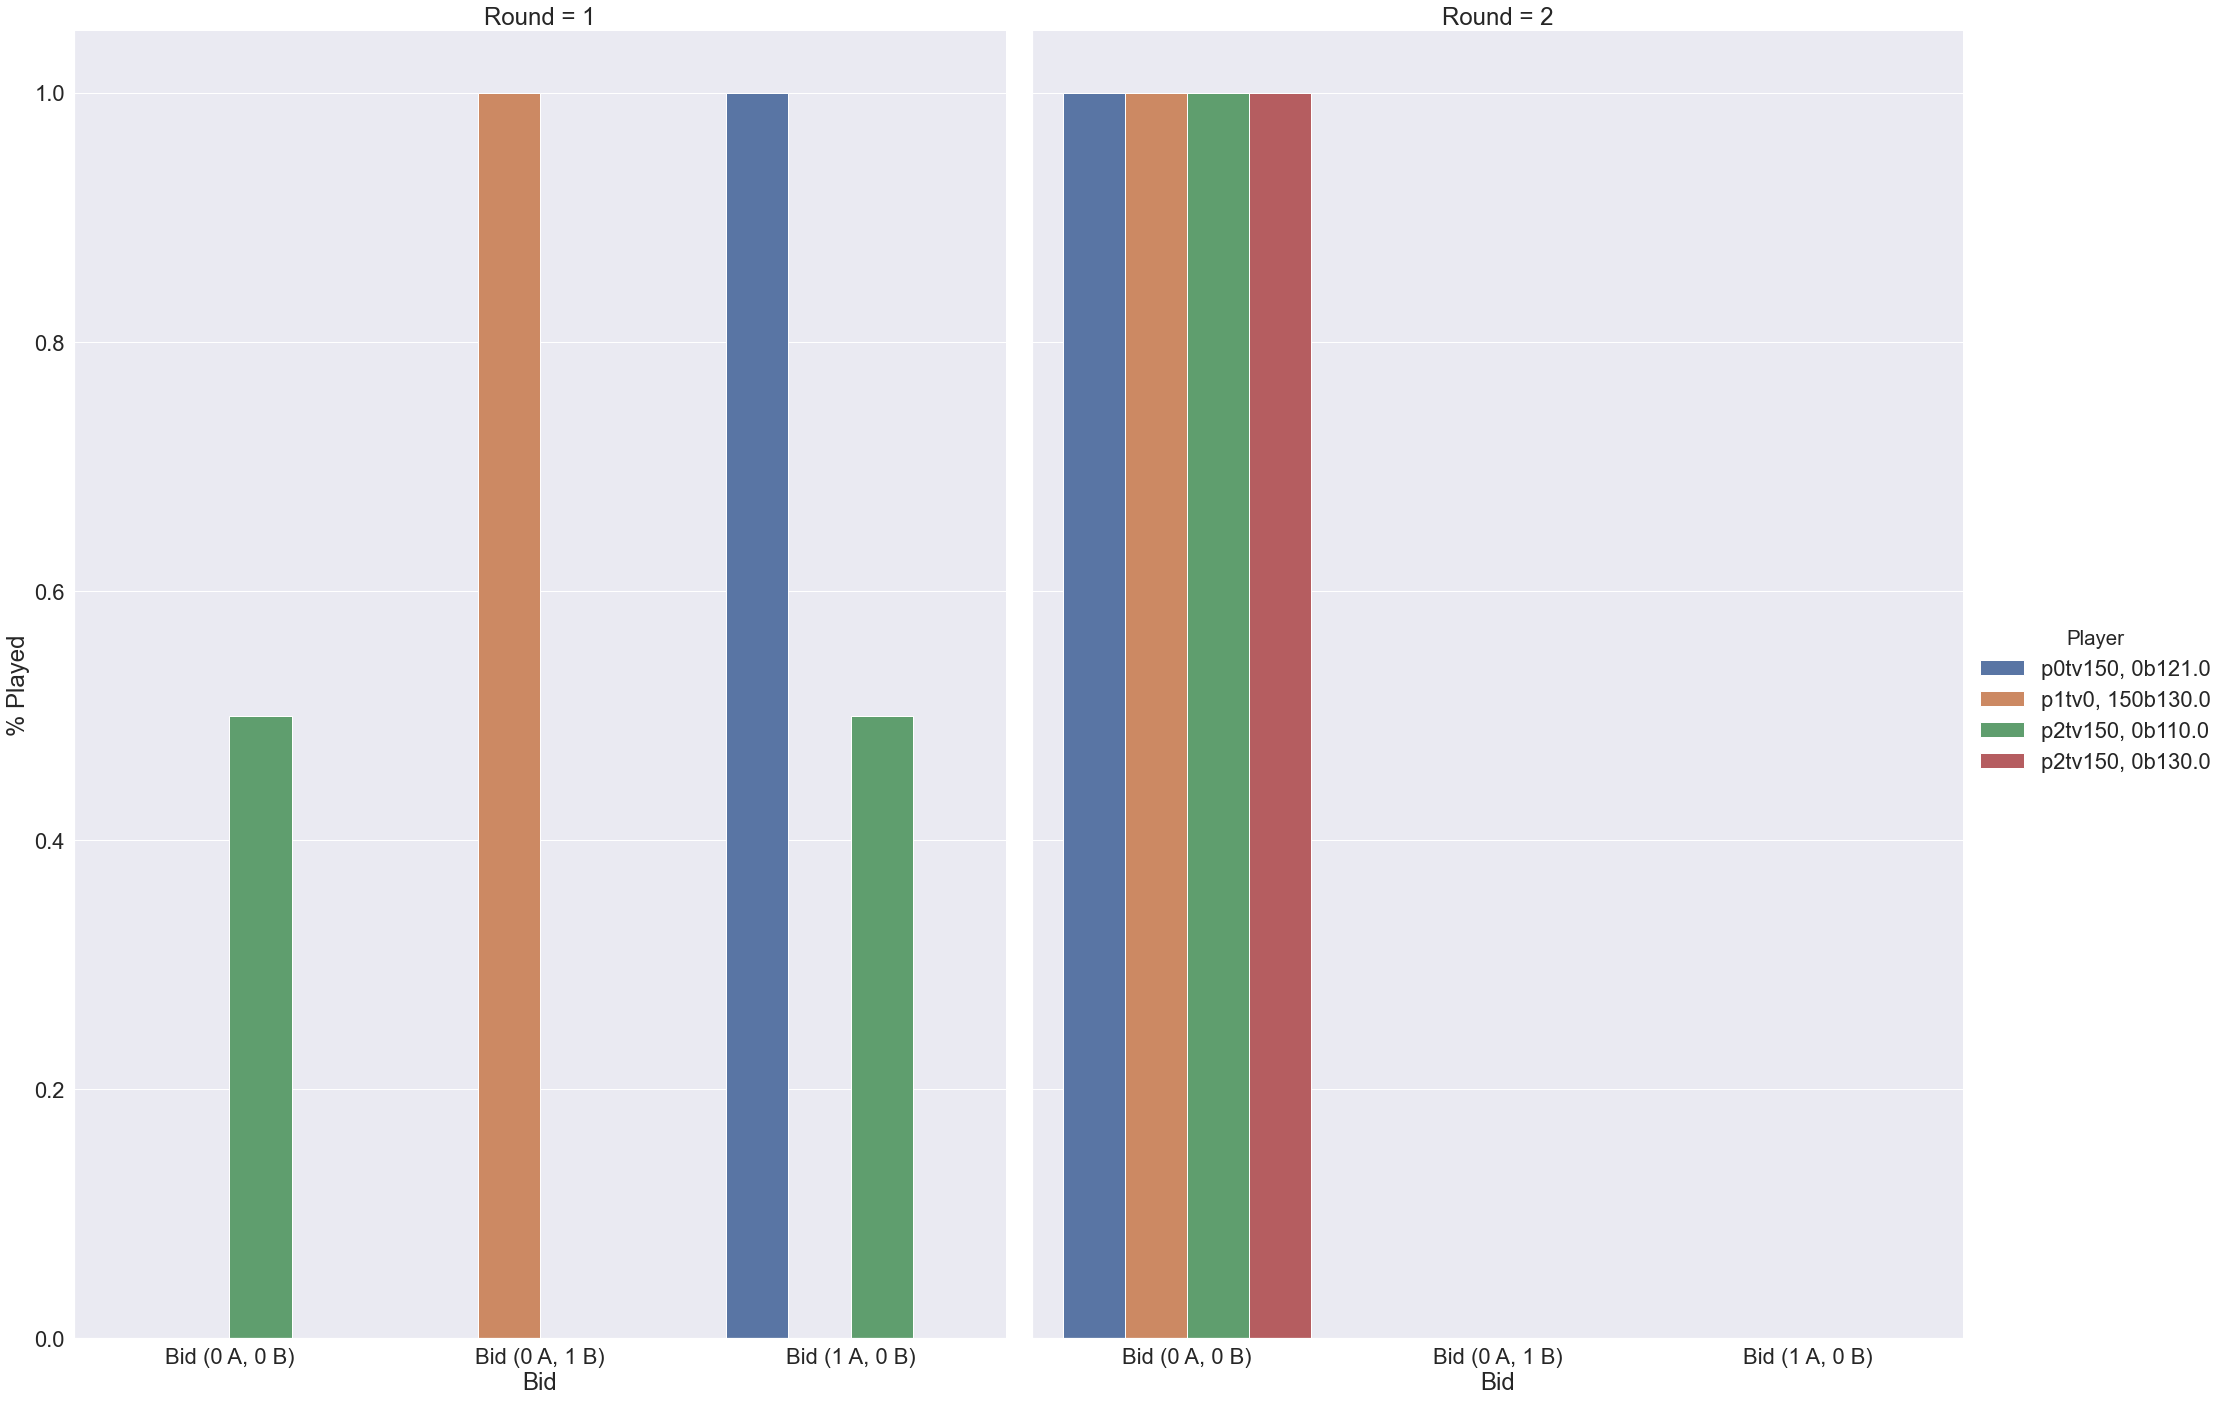

In [173]:
g = sns.catplot(x="Bid", y="% Played", hue="Player", col="Round", data=action_df, kind="bar", height=20, aspect=.7);
plt.savefig('probs.png', dpi=300)

In [23]:
alloc_cols = [c for c in df.columns if 'Allocation' in c]
goods = set([re.match(r'Allocation \d ([A-Z])', g).groups()[0] for g in alloc_cols])
goods

{'A', 'B'}

In [14]:
re.match?

Signature: re.match(pattern, string, flags=0)
Docstring:
Try to apply the pattern at the start of the string, returning
a Match object, or None if no match was found.
File:      ~/anaconda3/lib/python3.7/re.py
Type:      function


In [75]:
### How many info sets really don't need to exist, and what fraction are they of the total?
strat = pd.read_csv('/Users/newmanne/research/cfr/tmp/strategy.csv')
waste = strat.query('~terminal').query('`Bid (0 A, 0 B)` == 1').copy()
waste = waste[(pd.isnull(waste['Bid (1 A, 0 B)'])) & (pd.isnull(waste['Bid (0 A, 1 B)']))]

In [78]:
len(waste) / len(strat.query('~terminal'))

0.7364618330262636

In [77]:
len(waste)/len(strat)

0.7260747230829505